In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

In [4]:
n=100
M = np.diag(np.repeat(2,n),k=0) + np.diag(np.repeat(-1,n-1),k=1) + np.diag(np.repeat(-1,n-1),k=-1)
b = np.zeros(n)
b[0] = 1

In [5]:
M

array([[ 2, -1,  0, ...,  0,  0,  0],
       [-1,  2, -1, ...,  0,  0,  0],
       [ 0, -1,  2, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  2, -1,  0],
       [ 0,  0,  0, ..., -1,  2, -1],
       [ 0,  0,  0, ...,  0, -1,  2]])

In [6]:
b

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
val,vec = np.linalg.eig(M)

In [8]:
def f(x,m):
    return 1/2*M.dot(x).dot(x) - b.dot(x) + 1/2*m*x.dot(x)
def GD(x,m):
    return M.dot(x) - b + m*x

In [40]:
m=0.1
x_star = lambda m: np.linalg.pinv(M + m/2*np.diag(np.ones(100))).dot(b)
f_star = f(x_star(m),m)
f_star

-0.355555555555555

In [72]:
#### Nesterov for strongly smooth directly:
def AGD_ss(N,tol,m):
    x0 = np.repeat(0,n)
    L = 4 + m
    m0 = 4
    y0 = x0 - 1/L*GD(x0,m)
    v0 = - 1/L*GD(x0,m)
    value = [f(x0,m)]
    x_old = x0
    y_old = y0
    v_old = v0
    for i in np.arange(1,N+1):
        a = np.arange(1,i+1/2,1/2)
        A = a.sum()
        
        a_p = a[-1]*(m0 + m*(A-a[-1]))/(m0 + m*A)
        print(a_p,a[-1])

        x_new = (A-a[-1])/(A-a[-1]+a_p)*y_old + a_p/(A-a[-1]+a_p)*v_old
        y_new = x_new - 1/L*GD(x_new,m)
        v_new = (m0 + m*(A-a[-1]))/(m0 + m*A)*v_old + m*a[-1]/(m0 + m*A)*x_new - a[-1]/(m0+m*A)*GD(x_new,m)
        
        value.append(f(y_new,m))
        x_old = x_new; y_old = y_new; v_old = v_new
        #if (f(y_new,m) - f_star,m)**2 <= tol:
        #    break
    return y_new, value


In [73]:
x,value = AGD_ss(600,1,0.1)
len(value)

0.9756097560975611 1.0
1.9101123595505618 2.0
2.8200000000000003 3.0
3.7217391304347824 4.0
4.626865671641791 5.0
5.54140127388535 6.0
6.467391304347826 7.0
7.404651162790697 8.0
8.352 9.0
9.30795847750865 10.0
10.271084337349397 11.0
11.240105540897096 12.0
12.213953488372091 13.0
13.191752577319589 14.0
14.17279411764706 15.0
15.15650741350906 16.0
16.142433234421365 17.0
17.13020134228188 18.0
18.11951219512195 19.0
19.11012235817575 20.0
20.10183299389002 21.0
21.09448082319925 22.0
22.08793103448276 23.0
23.08207171314741 24.0
24.076809453471196 25.0
25.072065888812627 26.0
26.06777493606138 27.0
27.063880597014926 28.0
28.060335195530726 29.0
29.057097957045574 30.0
30.054133858267715 31.0
31.051412691060676 32.0
32.04890829694323 33.0
33.04659793814433 34.0
34.044461778471145 35.0
35.04248245289989 36.0
36.04064470918009 37.0
37.03893510815308 38.0
38.0373417721519 39.0
39.03585417294366 40.0
40.034462952326244 41.0
41.033159769799944 42.0
42.031937172774875 43.0
43.030788485607

601

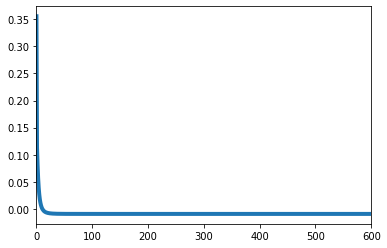

In [43]:
pd.Series(value - f_star).plot.line(linewidth = 4)

####  CG

According to exact line search, we have:
$$
h_k = \frac{<\nabla f(x_k),p_k>}{<(M + \frac{m}{2})p_k,p_k>}
$$
\
$$
\beta_{k}=\frac{\left\|\nabla f\left(x_{k+1}\right)\right\|^{2}}{\left\langle\nabla f\left(x_{k+1}\right)-\nabla f\left(x_{k}\right), p_{k}\right\rangle}
$$
\
$$
p_{k+1}=\nabla f\left(x_{k+1}\right)-\beta_{k} p_{k}
$$

In [44]:
#### CG:
def CG(N,tol,m):
    x0 = np.repeat(0,n)
    x_old = x0
    p_old = GD(x0,m)
    value = [f(x0,m)]
    for i in range(N):
        h = GD(x_old,m).dot(p_old)/ (M.dot(p_old) + m/2*p_old).dot(p_old)
        x_new = x_old - h*p_old
        beta = GD(x_new,m).dot(GD(x_new,m))/(GD(x_new,m) - GD(x_old,m)).dot(p_old)
        p_new = GD(x_new,m) - beta*p_old
        
        value.append(f(x_new,m))
        x_old = x_new
        p_old = p_new
        
        #if (f(x_new,m) - f_star,m)**2 <= tol:
        #    break
    return x_new, value

In [45]:
x,value = CG(600,1,0.1)
len(value)

601

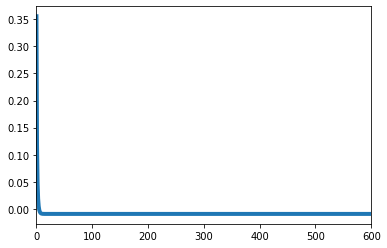

In [46]:
pd.Series(value - f_star).plot.line(linewidth = 4)

#### Heavy-Ball

$$
\mathbf{x}_{k+1}=\mathbf{x}_{k}-\alpha_{1} \nabla f\left(\mathbf{x}_{k}\right)+\alpha_{2}\left(\mathbf{x}_{k}-\mathbf{x}_{k-1}\right)
$$
\
$$
\alpha_{1}=\frac{4}{(\sqrt{L}+\sqrt{m})^{2}} \text { and } \alpha_{2}=\left(\frac{\sqrt{L}-\sqrt{m}}{\sqrt{L}+\sqrt{m}}\right)^{2}
$$

In [47]:
m=0.1
L = 4 + m
(L**(1/2) + m**(1/2))**2

5.480624847486569

In [64]:
#### Heavy-Ball:
def HB(N,tol,m):
    x0 = np.repeat(0,n)
    L = 4 + m
    alpha1 = 4/(L**(1/2) + m**(1/2))**2
    alpha2 = (L**(1/2) - m**(1/2))**2/(L**(1/2) + m**(1/2))**2
    value = [f(x0,m)]
    x1 = x0 - alpha1*GD(x0,m)
    value.append(f(x1,m))
    x_old = x1
    x_med = x1 - alpha1*GD(x1,m) + alpha2*(x1 - x0)
    for i in range(N):
        x_new = x_med - alpha1*GD(x_med,m) + alpha2*(x_med - x_old)        
        value.append(f(x_new,m))
        x_old = x_med
        x_med = x_new
        
        #if (f(x_new,m) - f_star,m)**2 <= tol:
        #    break
    return x_new, value

In [67]:
x,value = HB(600,1,0.1)
len(value)

602

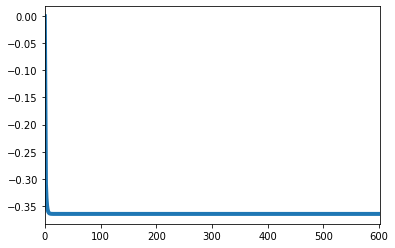

In [71]:
pd.Series(value).plot.line(linewidth = 4)

In [76]:
a = np.array([1,1,1])
a

array([1, 1, 1])

In [77]:
a.dot(a)

3

In [46]:
np.diag([1,2,3])

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])